In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load in ensemble to gene name dictionary (mm10)
gene_map = '/oasis/tscc/scratch/biom200/bms_2018/rna_seq/gene_names/mm10_genenames.txt'
gene = pd.read_table(gene_map, index_col=0)

# load in clean counts matrix
counts_file = '/oasis/tscc/scratch/biom200/bms_2018/rna_seq/analysis/featurecounts/LPS_clean_counts.txt'
counts = pd.read_table(counts_file, index_col=0)
counts.index = counts.index.map(gene['gene_name']) # use the dictionary to convert ensemble ids to gene names
counts.columns = counts.columns.str.replace('_',' ')

# TPM normalization
# https://www.rna-seqblog.com/rpkm-fpkm-and-tpm-clearly-explained/
counts_norm = counts.div(counts['Length'], axis=0) # normalize by gene length
counts_norm = counts_norm / counts_norm.sum(axis=0) * 1e6 # normalize by library size to 1M reads
counts_norm.drop('Length', axis=1, inplace=True) # we don't need the length column any more

# load in deseq results
res_file = '/oasis/tscc/scratch/biom200/bms_2018/rna_seq/analysis/deseq2/LPS_DE_genes_names.csv'
res = pd.read_table(res_file, index_col=0)
res_filt = res.dropna() # drop rows that contain NaN
res_filt = res_filt.loc[~pd.isnull(res_filt.index)] # drop indexes that contain NaN
res_filt = res_filt.sort_values('pvalue') #sort by the p-value columns

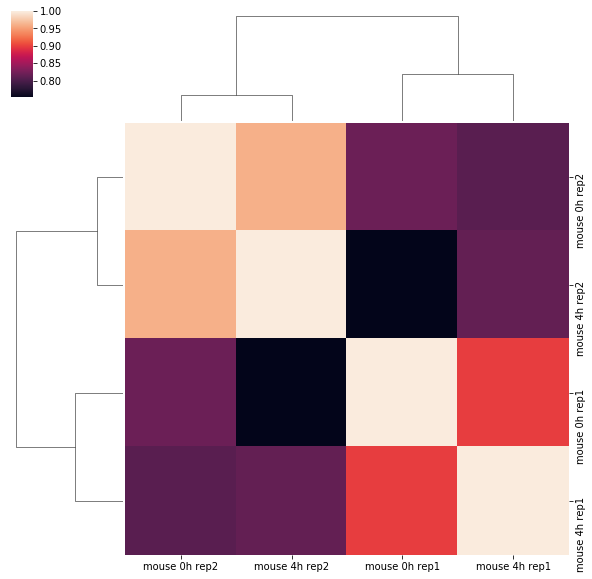

In [3]:
# basic correlation plot 

sns.clustermap(counts_norm.corr())

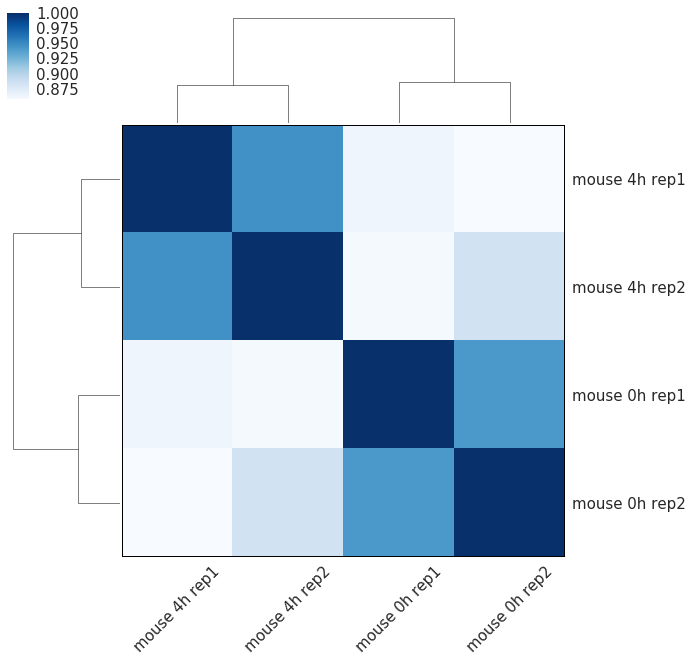

In [20]:
sns.set(font_scale=1.5) # easy way to make fonts bigger
plt.style.use('seaborn-white') # use a styling theme
# use spearman correlation, which is less biased towards outliers
cm = sns.clustermap(counts_norm.corr(method='spearman'), cmap='Blues')

# aesthetics
cm.ax_heatmap.set_xticklabels(cm.ax_heatmap.get_xticklabels(), rotation=45, ha='center') # rotate x tick label
cm.ax_heatmap.axvline(0, color='black', lw=2) # make a frame around the heatmap
cm.ax_heatmap.axvline(4, color='black', lw=2) # make a frame around the heatmap
cm.ax_heatmap.axhline(0, color='black', lw=2) # make a frame around the heatmap
cm.ax_heatmap.axhline(4, color='black', lw=2) # make a frame around the heatmap

plt.show()

In [5]:
# get the counts of the top 50 differentially expressed genes
res_top50 = res_filt.head(50) # subset for the top 50 most significant genes 
top50_genes = res_top50.index # we just want the gene names

top50_counts = counts_norm.loc[top50_genes] # get the normalized counts of the top 50 genes

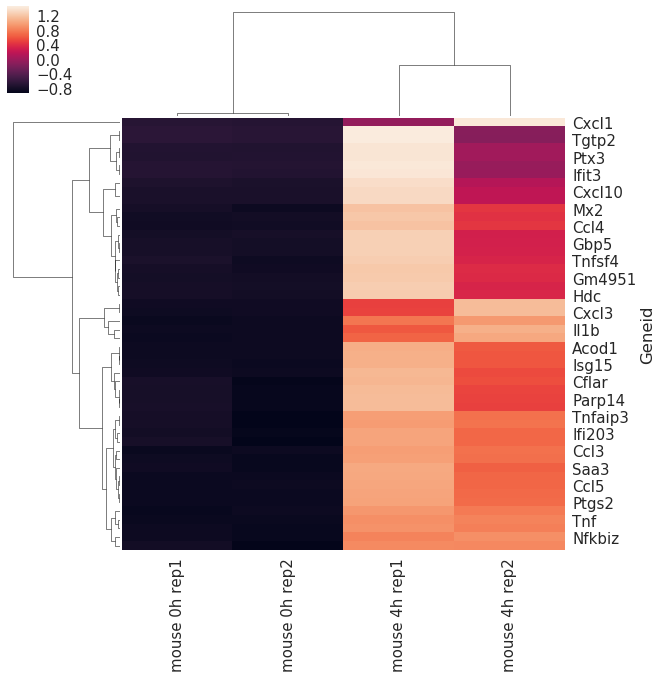

In [6]:
# make a barebones clustermap

sns.clustermap(top50_counts, z_score=0)

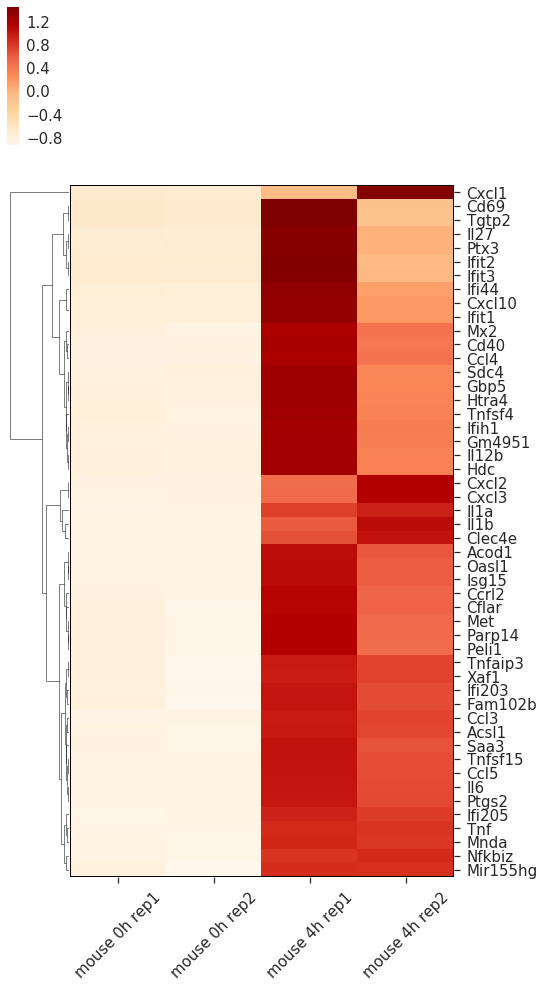

In [7]:
# make a pretty clustermap
cm = sns.clustermap(top50_counts, z_score=0,
                    col_cluster=False, yticklabels=1, 
                    cmap='OrRd', figsize=(8,16)) 

# aesthetics
cm.ax_heatmap.tick_params(axis='both', length=6, width=1.25) # turn axis ticks back on, sns.set turns it off
cm.ax_heatmap.set_xticklabels(cm.ax_heatmap.get_xticklabels(), rotation=45, ha='center') # rotate x tick labels
cm.ax_heatmap.set_ylabel('') # turn off y axis label

cm.ax_heatmap.axvline(0, color='black', lw=2) # make a frame around the heatmap
cm.ax_heatmap.axvline(len(top50_counts.columns), color='black', lw=2) # make a frame around the heatmap
cm.ax_heatmap.axhline(0, color='black', lw=2) # make a frame around the heatmap
cm.ax_heatmap.axhline(len(top50_counts), color='black', lw=2) # make a frame around the heatmap

plt.show()

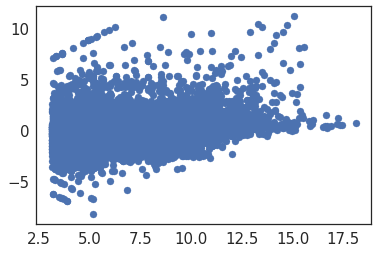

In [8]:
# make a MA plot

plt.scatter(np.log2(res_filt['baseMean']), res_filt['log2FoldChange'])

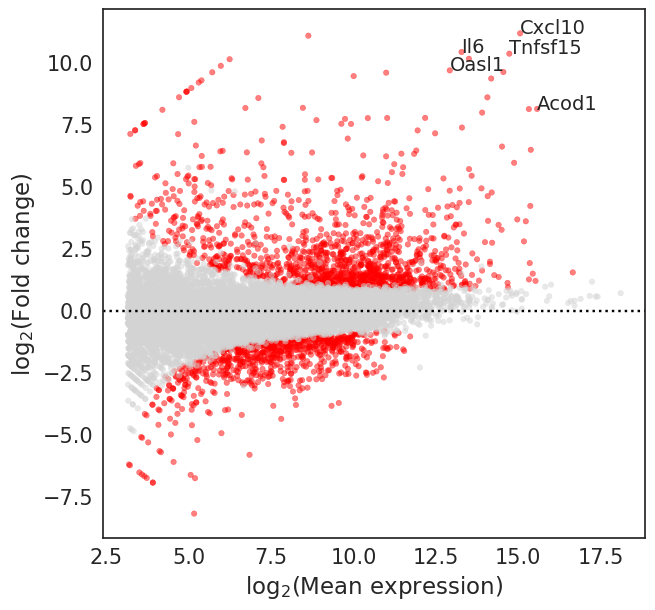

In [24]:
# make a prettier MA plot

pval_threshold = 0.05
cond = ['red' if p < pval_threshold else 'lightgrey' for p in res_filt['padj']] # set a coloring condition

fig, ax1 = plt.subplots(1,1, figsize=(7,7), dpi=100) # controls parameters about number of subplots (e.g. multiple grid plot)
ax1.scatter(np.log2(res_filt['baseMean']), res_filt['log2FoldChange'], color=cond, s=16, alpha=.5) # use smaller points

ax1.set_xlabel('log$_2$(Mean expression)') # set xlabel
ax1.set_ylabel('log$_2$(Fold change)') # set ylabel
ax1.axhline(0, color='black', linestyle='dotted') # make a horizontal dotted line at 0

# label the 5 top hits
for i,row in res_filt.head(5).iterrows():
    ax1.text(np.log2(row['baseMean']), row['log2FoldChange'], row.name, ha='left', fontsize=14)

plt.show()


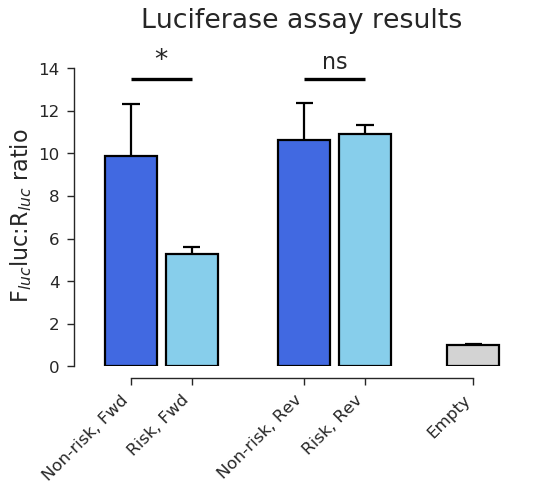

In [10]:
# real data

x_axis_range =[.65,1.35, 2.65,3.35, 4.6]
luc_data = {'Non-risk, Fwd':[8.354, 12.725, 8.506], 'Risk, Fwd':[5.078, 5.038, 5.661], 'Non-risk, Rev':[9.564, 9.692, 12.622], 
            'Risk, Rev':[10.777, 11.389, 10.598], 'Empty':[1.042, 0.92, 1.042]}
luc_data = pd.DataFrame.from_dict(luc_data).transpose()#.melt()
luc_data = luc_data.loc[['Non-risk, Fwd','Risk, Fwd','Non-risk, Rev','Risk, Rev','Empty'],:] # put them in the right order
luc_data['mean'] = luc_data.mean(axis=1)
luc_data['std'] = luc_data.iloc[:,:3].std(axis=1)
luc_data['xrange'] = x_axis_range


sns.set(font_scale=1.5)
plt.style.use('seaborn-white')
fig, ax1 = plt.subplots(1,1, figsize=(7,5), dpi=80)
bars = ax1.bar(luc_data['xrange'], luc_data['mean'], edgecolor='black', lw=2,
               color=['royalblue','skyblue','royalblue','skyblue','lightgrey'], width=.6)
ax1.vlines(x_axis_range, luc_data['mean'], luc_data['mean']+luc_data['std'], color='black', lw=2)
ax1.hlines(luc_data['mean']+luc_data['std'], luc_data['xrange']-.1, luc_data['xrange']+.1, color='black', lw=2)

ax1.hlines(13.5, 0.65, 1.35, color='black', lw=3)
ax1.text(1, 13.75, '*', ha='center', va='bottom', fontsize=24)
ax1.hlines(13.5, 2.65, 3.35, color='black', lw=3)
ax1.text(3, 13.75, 'ns', ha='center', va='bottom', fontsize=20)

ax1.set_xticks(x_axis_range)
sns.despine(trim=True, offset=10)
ax1.tick_params(axis='both', length=6, width=1.25, bottom=True, left=True)
ax1.set_xticklabels(['Non-risk, Fwd', 'Risk, Fwd', 'Non-risk, Rev', 'Risk, Rev', 'Empty'], rotation=45, ha='right')
ax1.set_ylabel('F$_{luc}$luc:R$_{luc}$ ratio', fontsize=20)
ax1.set_title('Luciferase assay results', fontsize=24, y=1.1)
plt.show()